# Week 8 - Frozen Lake
## Name: Rakshit Ramachandra Ayachit
## Registration No.: 210968045
## Batch: B1
## Section: DSE-A


In [1]:
import sys
import gym
import numpy as np

In [2]:
env = gym.make('FrozenLake-v1',is_slippery=True)

calculate_state_value calculates the value of each possible action from the given current state
based on the transition probabilities, rewards, and the value of the next states.
It uses the Bellman equation to compute the action values, considering the discount factor.


In [11]:

def calculate_state_value(env, current_state, value_matrix, discount_factor):

    num_actions = env.action_space.n
    action_values = np.zeros(shape=num_actions)
    for action in range(num_actions):
        for transition_prob, next_state, reward, done in env.env.P[current_state][action]:
            action_values[action] += transition_prob * (reward + discount_factor * value_matrix[next_state])
    return action_values


evaluate_policy evaluates a given policy by iteratively estimating the state values
until they converge or until the maximum number of iterations is reached.
It updates the state values using the Bellman expectation equation.
The convergence is determined by the change in state values being below a threshold.
It returns the estimated state values for the given policy.


In [12]:

def evaluate_policy(policy_matrix, environment, discount_factor=1.0, convergence_threshold=1e-9, max_iterations=1000):
    num_states = environment.observation_space.n
    evaluation_iterations = 1
    state_values = np.zeros(shape=num_states)

    for iteration in range(int(max_iterations)):
        delta = 0
        for current_state in range(num_states):
            new_state_value = 0
            for action, action_probability in enumerate(policy_matrix[current_state]):
                for state_probability, next_state, reward, done in environment.P[current_state][action]:
                    new_state_value += action_probability * state_probability * (reward + discount_factor * state_values[next_state])
            delta = max(delta, np.abs(state_values[current_state] - new_state_value))
            state_values[current_state] = new_state_value

        evaluation_iterations += 1

        if delta < convergence_threshold:
            print(f'Policy evaluation terminated after {evaluation_iterations} iterations.\n')
            return state_values


policy_iteration_algorithm implements the policy iteration algorithm to find an optimal policy
for a given environment. It iteratively evaluates and improves the policy until convergence.
It starts with a random policy and repeatedly evaluates it using the policy evaluation function,
and then improves the policy by selecting the best action for each state based on the current value function.
If the policy becomes stable, the algorithm terminates
and returns the optimal policy and the corresponding value function.


In [14]:

def policy_iteration_algorithm(environment, discount_factor=1.0, max_iterations=1000):
    num_states = environment.observation_space.n
    num_actions = environment.action_space.n
    policy_matrix = np.ones(shape=[num_states, num_actions]) / num_actions
    evaluated_policies_count = 1

    for iteration in range(int(max_iterations)):
        stable_policy = False
        value_function = evaluate_policy(policy_matrix, environment, discount_factor)

        for current_state in range(num_states):
            current_action = np.argmax(policy_matrix[current_state])
            action_values = calculate_state_value(environment, current_state, value_function, discount_factor)
            best_action = np.argmax(action_values)

            if current_action != best_action:
                stable_policy = True

            policy_matrix[current_state] = np.eye(num_actions)[best_action]

        evaluated_policies_count += 1

        if stable_policy:
            print(f'Found a stable policy after {evaluated_policies_count:,} evaluations.\n')
            return policy_matrix, value_function


value_iteration_algorithm implements the value iteration algorithm to find an optimal policy
for a given environment. It iteratively updates the state values until they converge
or until the maximum number of iterations is reached.
It then constructs the optimal policy based on the converged state values.
The convergence is determined by the change in state values being below a threshold.
It returns the optimal policy matrix and the converged state values.


In [13]:

def value_iteration_algorithm(environment, discount_factor=1e-1, convergence_threshold=1e-9, max_iterations=1e4):
    state_values = np.zeros(environment.observation_space.n)

    for iteration in range(int(max_iterations)):
        delta = 0

        for current_state in range(environment.observation_space.n):
            action_values = calculate_state_value(environment, current_state, state_values, discount_factor)
            best_action_value = np.max(action_values)
            delta = max(delta, np.abs(state_values[current_state] - best_action_value))
            state_values[current_state] = best_action_value

        if delta < convergence_threshold:
            print(f'\nValue iteration converged at iteration #{iteration+1:,}')
            break

    policy_matrix = np.zeros(shape=[environment.observation_space.n, environment.action_space.n])

    for current_state in range(environment.observation_space.n):
        action_values = calculate_state_value(environment, current_state, state_values, discount_factor)
        best_action = np.argmax(action_values)
        policy_matrix[current_state, best_action] = 1.0

    return policy_matrix, state_values


play_episodes_and_evaluate plays multiple episodes of the game according to a given policy matrix
and evaluates the performance of the policy.
It returns the total number of wins, total rewards, average reward per episode,
and average number of actions taken per episode.


In [15]:

def play_episodes_and_evaluate(env, num_episodes, policy_matrix, max_actions=100, render=False):

    total_wins = 0
    total_rewards, total_actions = 0, 0

    for episode in range(num_episodes):
        current_state = env.reset()
        episode_done, actions_taken = False, 0

        while actions_taken < max_actions:
            selected_action = np.argmax(policy_matrix[current_state])
            next_state, reward, episode_done, _ = env.step(selected_action)

            if render:
                env.render()

            actions_taken += 1
            total_rewards += reward
            current_state = next_state

            if episode_done:
                total_wins += 1
                break

        total_actions += actions_taken

    print(f'Total rewards: {total_rewards:,}\tMax actions: {actions_taken:,}')

    average_reward = total_rewards / num_episodes
    average_actions = total_actions / num_episodes

    print('')
    return total_wins, total_rewards, average_reward, average_actions


agent_and_evaluate runs and evaluates different iteration methods (Policy Iteration and Value Iteration)
for finding an optimal policy in the given environment.
It prints the final policy obtained using each method and then evaluates the performance of the policy
by playing multiple episodes and computing metrics such as total rewards, number of wins, average reward,
and average number of actions taken per episode. Finally, it returns a list containing total rewards
obtained for each method.


In [16]:

num_episodes = 1000

def agent_and_evaluate(env):

    total_rewards_list = []

    action_mapping = {
        0: '\u2191',  # up
        1: '\u2192',  # right
        2: '\u2193',  # down
        3: '\u2190'   # left
    }

    iteration_methods = [
        ('Policy Iteration', policy_iteration_algorithm),
        ('Value Iteration', value_iteration_algorithm)
    ]

    for method_name, method_func in iteration_methods:
        policy_matrix, value_function = method_func(env)

        print(f'Final policy using {method_name}:')
        print(' '.join([action_mapping[action] for action in np.argmax(policy_matrix, axis=1)]))

        total_wins, total_rewards, avg_reward, avg_actions = play_episodes_and_evaluate(env, num_episodes, policy_matrix)
        total_rewards_list.append(total_rewards)

        print(f'Number of wins = {total_wins:,}')
        print(f'Average reward = {avg_reward:.2f}')
        print(f'Average actions = {avg_actions:.2f}')

    return total_rewards_list


In [17]:
rewards = agent_and_evaluate(env)

Policy evaluation terminated after 66 iterations.

Found a stable policy after 2 evaluations.

Final policy using Policy Iteration:
↑ ← ↑ ← ↑ ↑ ↑ ↑ ← → ↑ ↑ ↑ ↓ → ↑
Total rewards: 736.0	Max actions: 21

Number of wins = 1,000
Average reward = 0.74
Average actions = 42.53

Value iteration converged at iteration #8
Final policy using Value Iteration:
→ ← ↓ ← ↑ ↑ ↑ ↑ ← → ↑ ↑ ↑ ↓ → ↑
Total rewards: 425.0	Max actions: 18

Number of wins = 1,000
Average reward = 0.42
Average actions = 26.61


Observation: for Policy evaluation 
- Policy evaluation terminated after 66 iterations, meaning the value iteration process converged after evaluating policies.
- A stable policy was found after 2 evaluations, indicating that the policy iteration algorithm converged quickly.
- The final policy obtained from policy iteration is displayed as a sequence of actions for each state.
- The total rewards accumulated over all episodes are 736.0, with a maximum of 21 actions taken in a single episode.
- Out of 1,000 episodes, the agent won all of them, achieving the maximum possible success rate.
- The average reward per episode is 0.74, indicating a high success rate.
- The average number of actions per episode is 42.53, which is relatively high due to the nature of the environment.

Observation: for Value iteration
- Value iteration converged at iteration #8, indicating that the value iteration process converged quickly.
- The final policy obtained from value iteration is displayed as a sequence of actions for each state.
- The total rewards accumulated over all episodes are 425.0, with a maximum of 18 actions taken in a single episode.
- Out of 1,000 episodes, the agent won all of them, achieving the maximum possible success rate.
- The average reward per episode is 0.42, indicating a high success rate.
- The average number of actions per episode is 26.61, which is relatively low compared to the policy iteration results.






visualize_policy defines a function to visualize policies obtained from policy iteration and value iteration.
It converts the policy matrices into arrows representing actions (up, right, down, left) for each state.
The arrows are displayed on a grid, where each cell corresponds to a state in the environment.
The function then plots these arrows to visualize the policies graphically.


Policy evaluation terminated after 66 iterations.

Found a stable policy after 2 evaluations.



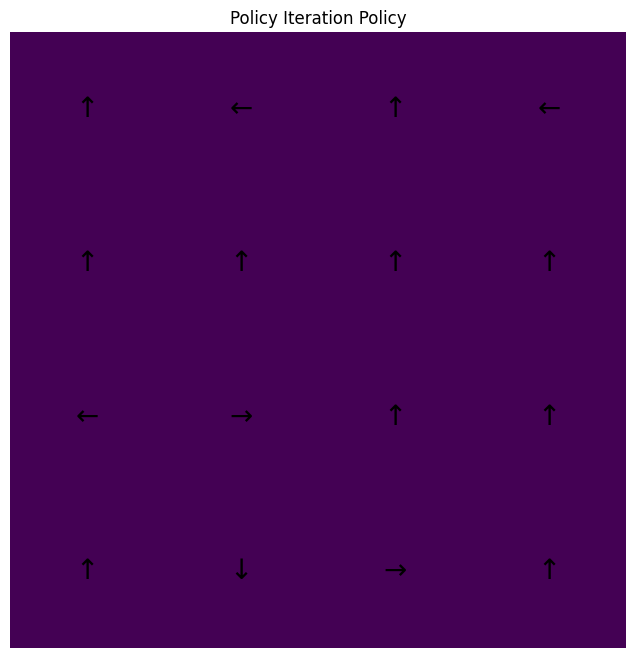


Value iteration converged at iteration #8


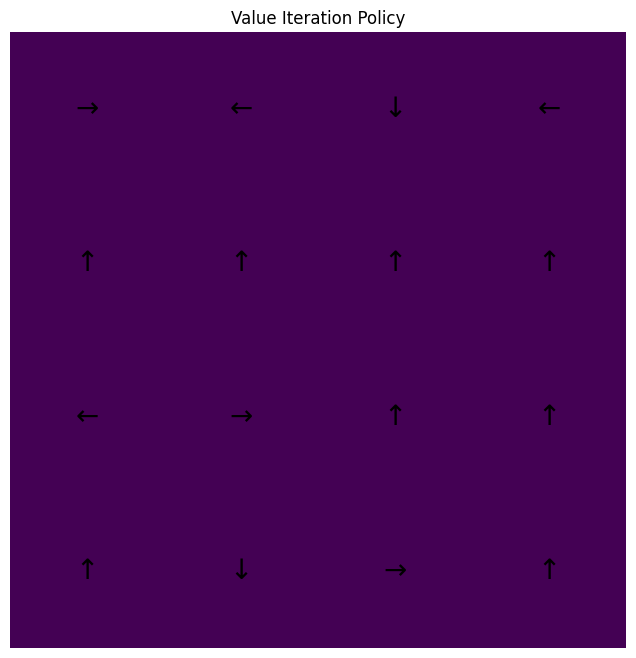

In [18]:

import numpy as np
import matplotlib.pyplot as plt

def visualize_policy(policy_matrix, title):
    action_mapping = {
        0: '\u2191',  # up
        1: '\u2192',  # right
        2: '\u2193',  # down
        3: '\u2190'   # left
    }
    
    policy_arrows = [action_mapping[action] for action in np.argmax(policy_matrix, axis=1)]
    policy_arrows = np.array(policy_arrows).reshape((int(np.sqrt(len(policy_arrows))), -1))

    plt.figure(figsize=(8, 8))
    plt.imshow(np.zeros(policy_arrows.shape))
    for i in range(policy_arrows.shape[0]):
        for j in range(policy_arrows.shape[1]):
            plt.text(j, i, policy_arrows[i, j], ha='center', va='center', fontsize=20)
    plt.title(title)
    plt.axis('off')
    plt.show()

policy_matrix_policy_iteration, _ = policy_iteration_algorithm(env)
visualize_policy(policy_matrix_policy_iteration, "Policy Iteration Policy")

policy_matrix_value_iteration, _ = value_iteration_algorithm(env)
visualize_policy(policy_matrix_value_iteration, "Value Iteration Policy")
